## MDMA

In [1]:
#Libraries 
import os
import time
import math
import numpy as np
import pandas as pd
import scipy
import scipy.signal as spsg
from scipy import stats
from scipy.io import loadmat
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import seaborn as sns
import random
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.spatial.distance import cityblock



random.seed(42)

### Reading Data

In [2]:
# Read the data
data_path= "C:/Users/diego/Desktop/phase_coherance_consciousness/data"

#Some of the data is corrupeted, we chose manually the patiens we want to read.
num_patients=[0,1,2,3,4,5,7,8,9,10,11,12,14,15,17,18,19,20]
num=len(num_patients)

data_MDMA = os.path.join(data_path, "MDMA_TS_FC.mat")
data_MDMA = loadmat(data_MDMA)
data_MDMA = data_MDMA["DataCorrel"].flatten()
MDMACAT = np.hstack([data_MDMA["TS_MDMA2"][i] for i in num_patients])
MPCAT = np.hstack([data_MDMA["TS_PCB2"][i] for i in num_patients])

MDMA_Signals = np.hstack((MDMACAT, MPCAT))
print(f"MDMA concatenated signals: {MDMA_Signals.shape} from {data_MDMA.shape[0]} patients.")

MDMA concatenated signals: (90, 6316) from 21 patients.


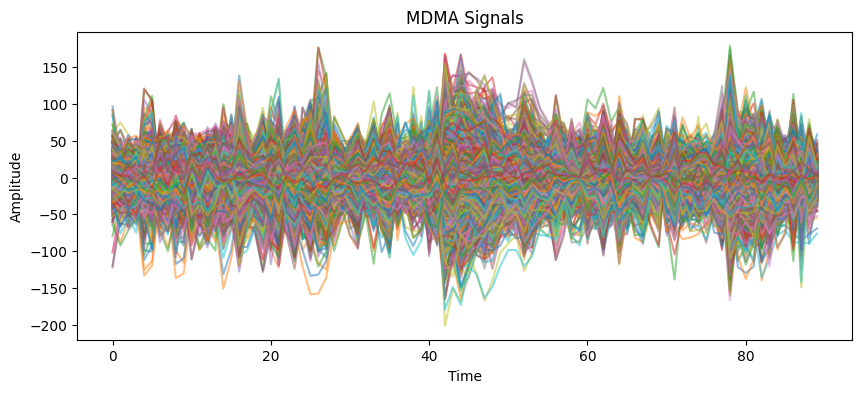

In [3]:
# Initial visualization of the Bold Signals (Time Series)
plt.figure(figsize=(10, 4))
plt.plot(MDMA_Signals, alpha=0.5)
plt.title("MDMA Signals")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Extract Size and Features

In [4]:
#Number of Regions and Total Time
ROI,time_length = MDMA_Signals.shape

# Loop over each region to extract the lenght of each signal.
Time_per_subj = np.zeros(ROI, dtype=int)
for i in range(ROI):
    Time_per_subj[i] = len(MDMA_Signals[i])


print(f" Number of Regions (ROI): {ROI} \n Total Time: {time_length}")

 Number of Regions (ROI): 90 
 Total Time: 6316


### Import the Connectoma 

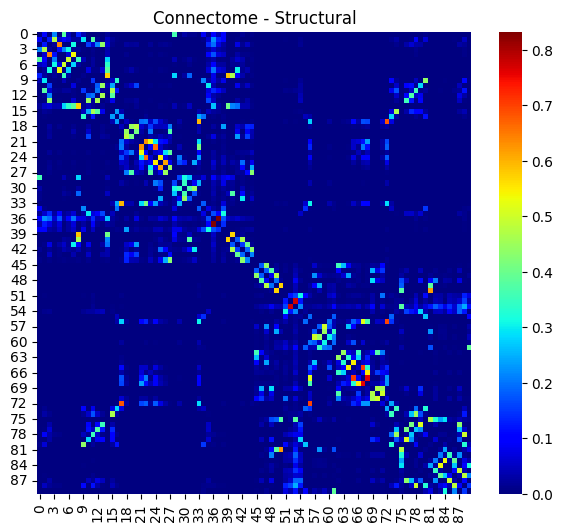

In [5]:
# Import the atlas
data_connectome = os.path.join(data_path, "./structural.mat")
CC = loadmat(data_connectome)['A']

# Plot it
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(CC, cmap='jet',cbar=True, ax=ax)
ax.set_title(f"Connectome - Structural")
plt.show()

In [6]:
np.info(CC)

class:  ndarray
shape:  (90, 90)
strides:  (8, 720)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x22beea27790
byteorder:  little
byteswap:  False
type: float64


### Preprocess Functions 

In [7]:
# Function to apply a Butterworth bandpass filter to a time series.
# It is particularly useful for removing noise and smoothing the signal in the specified frequency range.
def butterworth_filtering(ts):
    """
    Apply a Butterworth bandpass filter to the input time series `ts`.

    Parameters:
    ts : array-like
        The input time series (1D or 2D array).
        
    Returns:
    filtered_ts : array-like
        The filtered time series, same shape as input.
        
    Notes:
    - The filter settings are dependent on the experimental setup (TR = 2.4 seconds).
    - A 3rd-order Butterworth bandpass filter is applied with cutoff frequencies of 0.01 and 0.2 times the Nyquist frequency.
    - The Nyquist frequency is determined by the repetition time (TR = 2.4s).
    """
    # Parameters
    n_order = 3  # Filter order
    TR = 2.4  # Repetition time (in seconds, relevant for fMRI experiments)
    Nyquist_freq = 0.5 / TR  # Nyquist frequency (half the sampling rate)
    low_f = 0.01 / Nyquist_freq  # Low cutoff frequency (fraction of Nyquist)
    high_f = 0.2 / Nyquist_freq  # High cutoff frequency (fraction of Nyquist)
    
    # Design the Butterworth bandpass filter
    b, a = spsg.iirfilter(n_order, (low_f, high_f), btype='bandpass', ftype='butter', output='ba')
    
    # Apply the filter to the time series using zero-phase filtering
    filtered_ts = spsg.filtfilt(b, a, ts, axis=-1)
    
    return filtered_ts

In [8]:
def adif(a, b):
    """
    Calculate the angular difference between two angles `a` and `b` in radians.

    Parameters:
    a, b : float
        The input angles in radians.
        
    Returns:
    float
        The angular difference between the two angles, always in the range [0, π]. The smallest angel diffence.
    """
    if abs(a - b) > math.pi:
        return 2 * math.pi - abs(a - b)
    else:
        return abs(a - b)


### Phase difference between each pair of regions

In [9]:
timeseriedata = np.empty((ROI, time_length))
Amplitude = np.empty((ROI, time_length))
Phases = np.empty((ROI, time_length))

# For each Region we preprocess the signal to exctract instantaneous phase
for i in range(ROI):

    #Extract the signal
    ts = MDMA_Signals[i,:]

    # Normalize the signal using Z-score
    ts_z = stats.zscore(ts)

    # Subtract the mean
    ts_z = ts_z-np.mean(ts_z,axis=0)

    # Apply the Butterworth filter 
    #ts_filtered = butterworth_filtering(ts_z)
    ts_filtered = ts_z
    
    timeseriedata[i, :] = ts_filtered

    # Perform the Hilbert transform
    hilbert_tf = spsg.hilbert(ts_z, axis=-1)
    Amplitude[i, :] = np.abs(hilbert_tf)

    # Instantaneous phase
    Phases[i, :] = np.angle(hilbert_tf)

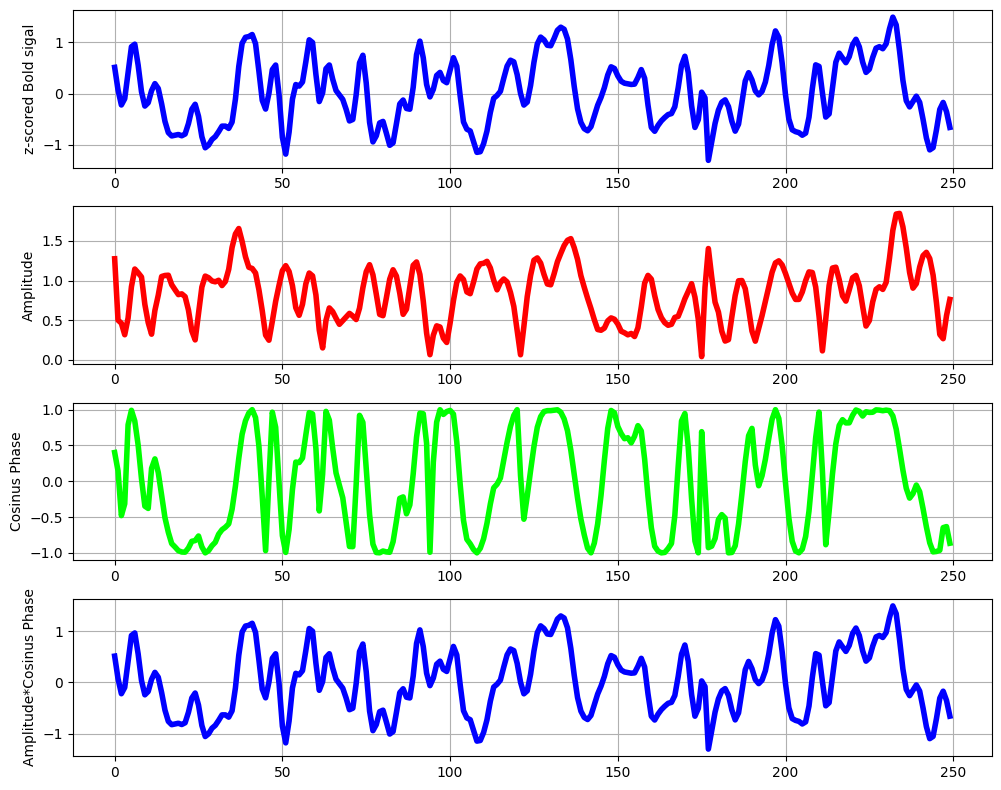

In [10]:
def createfigure(Y1, Y2, Y3, Y4):
    """
    Creates a figure with 4 vertical subplots to visualize:
    - Y1: Z-scored signal (e.g., bold)
    - Y2: Amplitude
    - Y3: Cosine of the phase
    - Y4: Amplitude * cosine of the phase
    """

    fig, axs = plt.subplots(4, 1, figsize=(10, 8))
    
    axs[0].plot(Y1, linewidth=4, color=[0, 0, 1])
    axs[0].set_ylabel('z-scored Bold sigal')
    axs[0].grid(True) 
    
    axs[1].plot(Y2, linewidth=4, color=[1, 0, 0])
    axs[1].set_ylabel('Amplitude')
    axs[1].grid(True)
    
    
    axs[2].plot(Y3, linewidth=4, color=[0, 1, 0])
    axs[2].set_ylabel('Cosinus Phase')
    axs[2].grid(True)
    
    axs[3].plot(Y4, linewidth=4, color=[0, 0, 1])
    axs[3].set_ylabel('Amplitude*Cosinus Phase')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

#We replicate a signal
Y1 = timeseriedata[0, :250]
Y2 = Amplitude[0, :250]
Y3 = np.cos(Phases[0, :250])
Y4 = Amplitude[0, :250] * np.cos(Phases[0, :250])
createfigure(Y1, Y2, Y3, Y4)

### Vectorized Computation for each time instant 

In [11]:
# Number of pairs (only the lower part of the matrix): ROI*(ROI-1)/2
row_idx, col_idx = np.tril_indices(ROI, k=-1)
sorted_indices = np.lexsort((row_idx, col_idx))
lower_indices_corrected = (row_idx[sorted_indices], col_idx[sorted_indices])


num_pairs = len(lower_indices_corrected[0])
pattern = np.empty((num_pairs, time_length))


# Vectorized computation for each time instant
for t in range(time_length):
    patt = np.empty((ROI, ROI))
    for i in range(ROI):
        for j in range(i):
            patt[i,j] = np.cos(adif(Phases[i,t],Phases[j,t]))
    pattern[:, t] = patt[lower_indices_corrected]
    

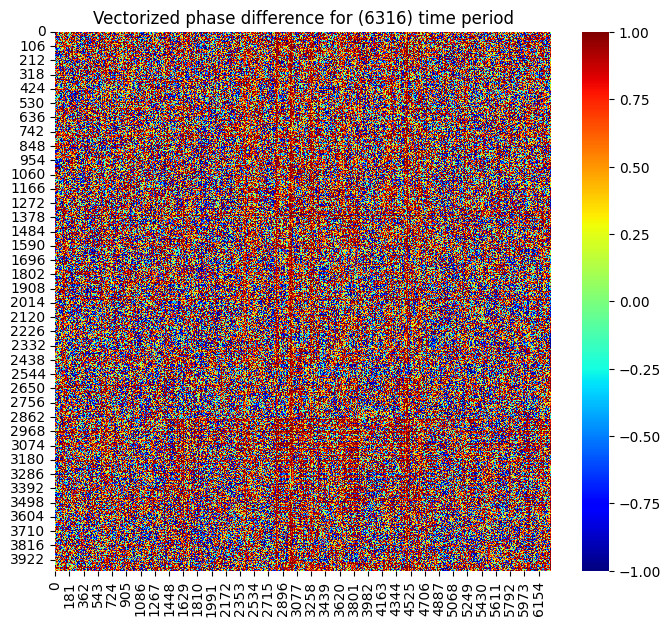

In [12]:
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(pattern, cmap='jet', vmin=-1, vmax=1, cbar=True, ax=ax)
ax.set_title(f"Vectorized phase difference for ({time_length}) time period")
plt.show()

### Remove Empty Images

In [13]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore


all_pattern2D = pattern.T


# Empty Images
print("Size before removing empty images:", all_pattern2D.shape)
good_pattern = np.sum(np.abs(all_pattern2D), axis=1) > 0
all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing empty images:", all_pattern2D.shape)

# Outliers
D = squareform(pdist(all_pattern2D, metric='cityblock'))  
D = zscore(np.mean(D, axis=1))  
good_pattern = D < 3 
all_pattern2D = all_pattern2D[good_pattern, :]  
print("Size after removing outliers:", all_pattern2D.shape)


Size before removing empty images: (6316, 4005)
Size after removing empty images: (6316, 4005)
Size after removing outliers: (6316, 4005)


### K-Means

In [14]:
# Parameters
opts = {"max_iter": 200}
Kmeans_results = {} 
aux_data = pattern.T 

# Manhattan distance
def compute_manhattan_distance(data_point, centroids, cluster_labels):
    return cityblock(data_point, centroids[cluster_labels])

# KMeans clustering for each k (currently just k=5)
for k in [5]:
    kmeans = KMeans(n_clusters=k, max_iter=opts["max_iter"], n_init=1, random_state=0)
    kmeans.fit(aux_data)

    cidx_Pha = kmeans.labels_
    ctrs_Pha = kmeans.cluster_centers_

    #Manhattan distances
    sum_D_Pha = np.sum([compute_manhattan_distance(aux_data[i], ctrs_Pha, cidx_Pha[i]) for i in range(aux_data.shape[0])])

    Kmeans_results[k] = {
        "cidx_Pha": cidx_Pha,
        "ctrs_Pha": ctrs_Pha,
        "sum_D_Pha": sum_D_Pha
    }

# Verify Dimensions
print(f"cidx_Pha shape: {Kmeans_results[5]['cidx_Pha'].shape}")
print(f"ctrs_Pha shape: {Kmeans_results[5]['ctrs_Pha'].shape}")
print(f"sum_D_Pha: {Kmeans_results[5]['sum_D_Pha']}")


cidx_Pha shape: (6316,)
ctrs_Pha shape: (5, 4005)
sum_D_Pha: 14502300.102813087


### Visualization

In [16]:
# Clustering States
n_state = 5
cidx = Kmeans_results[n_state]['cidx_Pha']  
L = cidx.shape[0]  
T_shift = 9  

# Reordering the structural connectivity matrix
id_aal = np.arange(1, 91) 
id_deco = np.concatenate([np.linspace(1, 89, 45, dtype=int), np.linspace(2, 90, 45, dtype=int)[::-1]])
deco_to_aal_mapping = np.searchsorted(id_aal, id_deco)  
CC2 = CC[np.ix_(deco_to_aal_mapping, deco_to_aal_mapping)] 
VC = CC.flatten().astype(np.float64)

# Compute correlations between centroids and connectome
CCA = np.zeros(n_state)
for i in range(n_state):
    centroid_vector = Kmeans_results[n_state]['ctrs_Pha'][i, :]
    QQ = squareform(centroid_vector) 
    VA = QQ.flatten()
    MC = np.corrcoef(VA, VC)  # Correlation with the connectome
    CCA[i] = MC[0, 1]

B = np.sort(CCA)
I = np.argsort(CCA)


rate = np.zeros(n_state)
ratea = np.zeros(n_state)
rateb = np.zeros(n_state)

denom = L - 2 * T_shift 

for bst in range(n_state):
    rate[bst]  = np.sum(cidx == I[bst]) / denom
    ratea[bst] = np.sum(cidx[:3465] == I[bst]) / denom
    rateb[bst] = np.sum(cidx[3466:6919] == I[bst]) / denom

# Compute cumulative time spent per subject
times_matrix_k = np.zeros((18, 2))
times_matrix_p = np.zeros((18, 2))

for i in range(18):
    size_value_k = data_MDMA[i]['TS_MDMA2'].shape[1]
    size_value_p = data_MDMA[i]['TS_PCB2'].shape[1]
    times_matrix_k[i, 0] = size_value_k
    times_matrix_p[i, 0] = size_value_p
    times_matrix_k[i, 1] = size_value_k if i == 0 else times_matrix_k[i-1, 1] + size_value_k
    times_matrix_p[i, 1] = size_value_p if i == 0 else times_matrix_p[i-1, 1] + size_value_p

# Compute state rates per segment
scratekt = np.zeros((15, n_state))
scratektp = np.zeros((15, n_state))

for s in range(15):
    for j in range(n_state):
        if s == 0:
            scratekt[s, j] = np.sum(cidx[:int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465:3465 + int(times_matrix_p[s, 1])] == I[j]) / times_matrix_p[0, 1]
        else:
            scratekt[s, j] = np.sum(cidx[int(times_matrix_k[s-1, 1]):int(times_matrix_k[s, 1])] == I[j]) / times_matrix_k[0, 1]
            scratektp[s, j] = np.sum(cidx[3465 + int(times_matrix_p[s-1, 1]): 3465 + int(times_matrix_p[s, 1]) - 20] == I[j]) / times_matrix_p[0, 1]

# Prepare group comparison matrix
grp = np.concatenate([np.zeros(15), np.ones(15)])
CH = np.zeros((30, n_state))

for i in range(n_state):
    CH[:, i] = np.concatenate([scratekt[:, i], scratektp[:, i]])


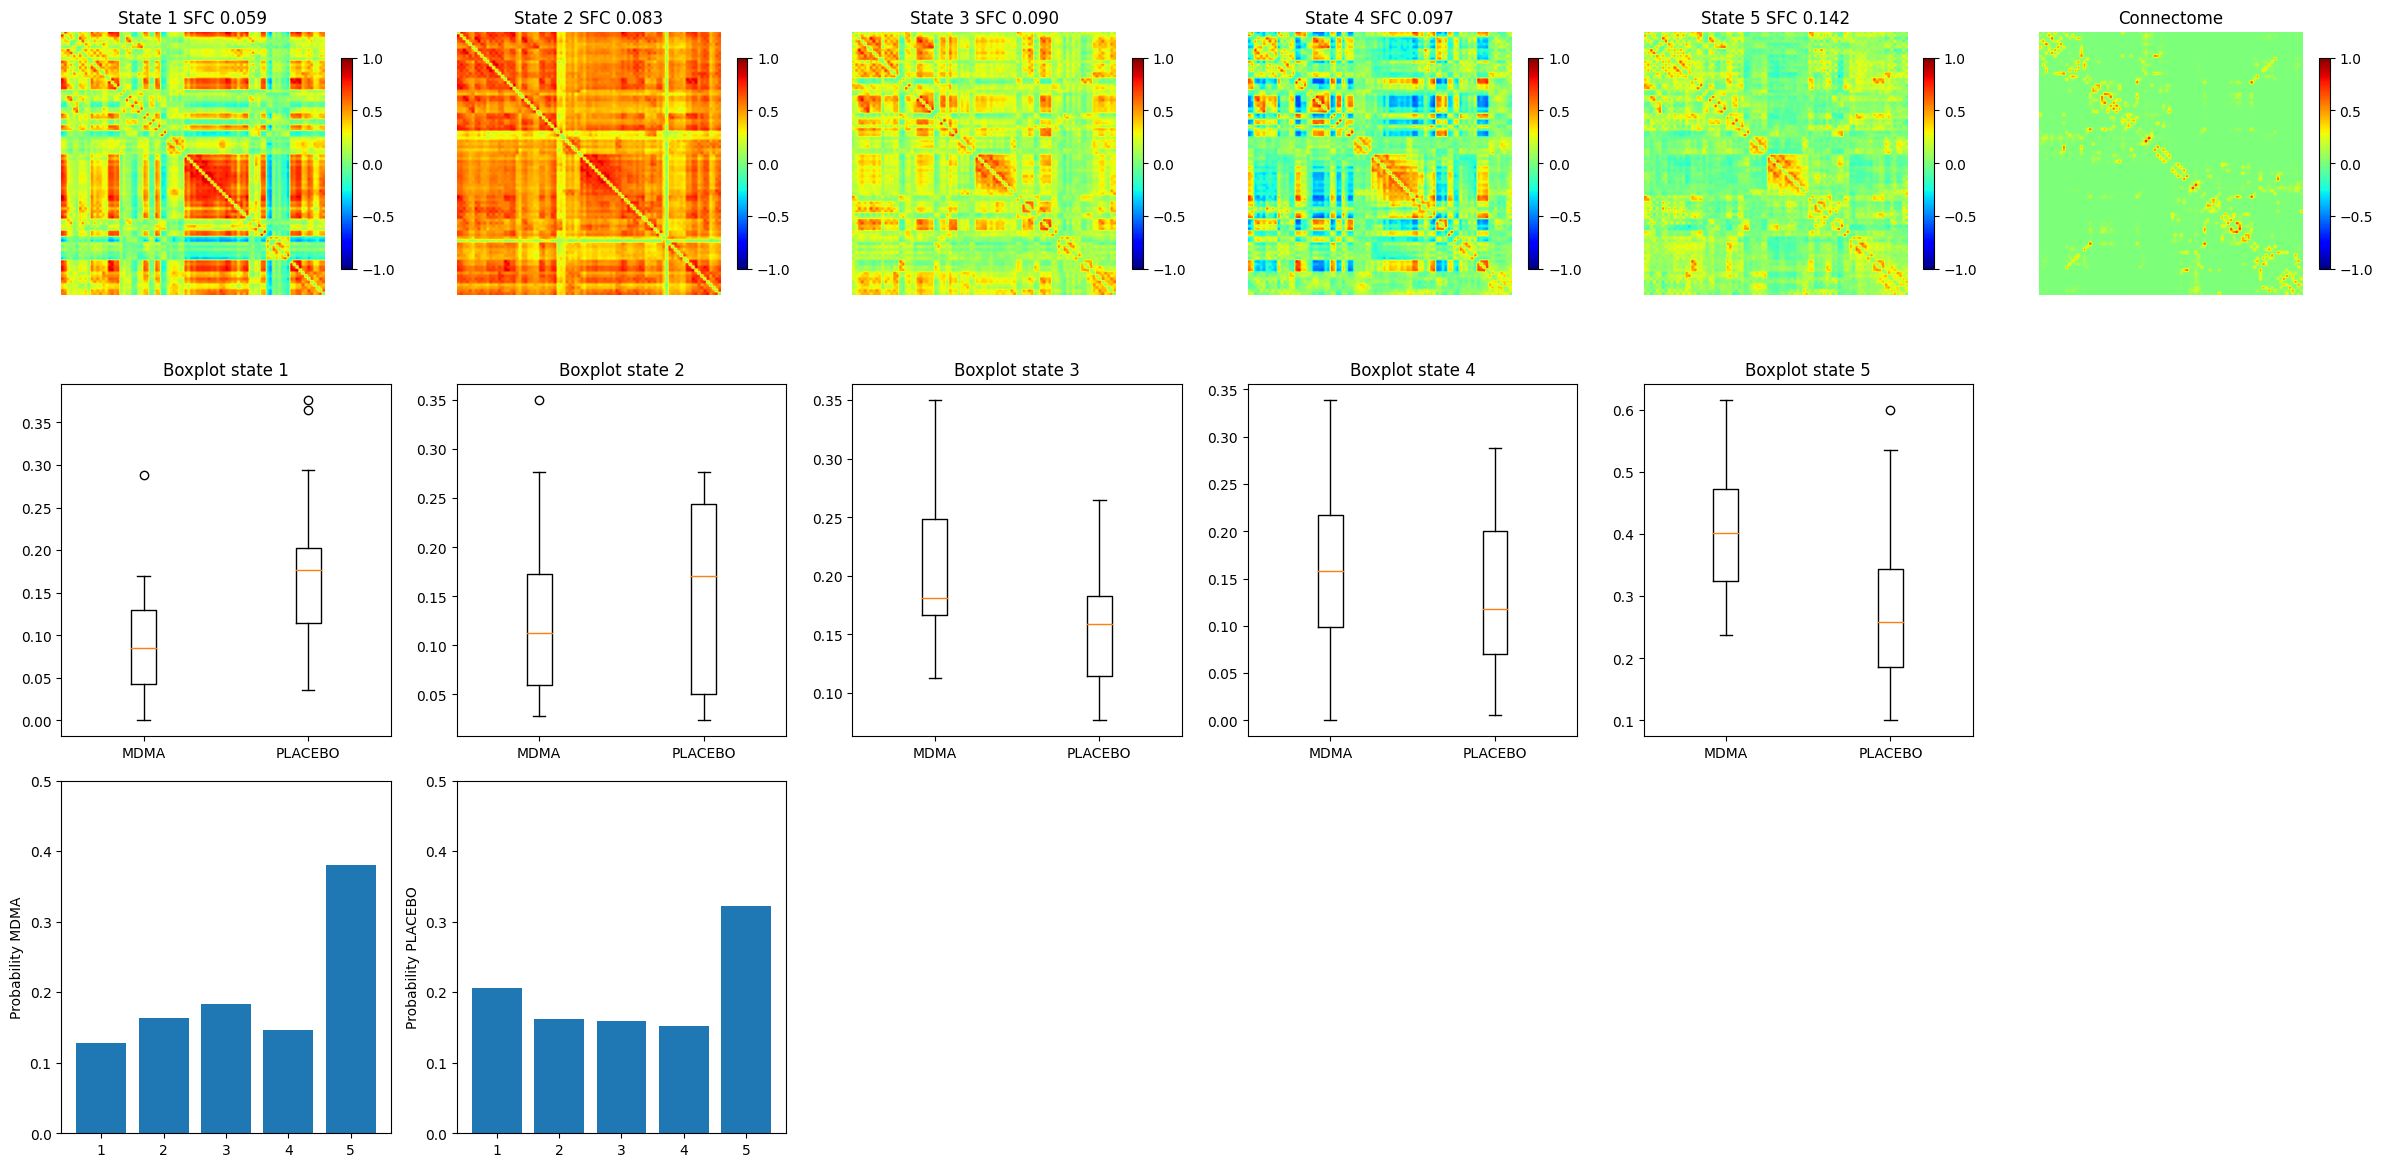

In [17]:
fig, axs = plt.subplots(3, n_state + 1, figsize=(4*(n_state+1), 12))

#Correlation matrices of each state
for i in range(n_state):
    QQ = squareform(Kmeans_results[n_state]['ctrs_Pha'][I[i], :])
    im = axs[0, i].imshow(QQ, vmin=-1, vmax=1, cmap='jet')
    axs[0, i].set_title(f"State {i+1} SFC {B[i]:.3f}")
    axs[0, i].axis("off")
    plt.colorbar(im, ax=axs[0, i], shrink=0.6)

#Connectome matrix
axs[0, n_state].imshow(CC, vmin=-1, vmax=1, cmap='jet')
axs[0, n_state].set_title("Connectome")
axs[0, n_state].axis("off")
plt.colorbar(im, ax=axs[0, n_state], shrink=0.6)

#Boxplots for each state
for i in range(n_state):
    axs[1, i].boxplot([CH[:15, i], CH[15:, i]], labels=["MDMA", "PLACEBO"])
    axs[1, i].set_title(f"Boxplot state {i+1}")
axs[1, n_state].axis('off')

#Bar plots for state probabilities in MDMA and PLACEBO
axs[2, 0].bar(np.arange(1, n_state+1), ratea/np.sum(ratea))
axs[2, 0].set_ylim([0, 0.5])
axs[2, 0].set_ylabel('Probability MDMA')

axs[2, 1].bar(np.arange(1, n_state+1), rateb/np.sum(rateb))
axs[2, 1].set_ylim([0, 0.5])
axs[2, 1].set_ylabel('Probability PLACEBO')

# Hide remaining columns
for j in range(2, n_state+1):
    axs[2, j].axis('off')

plt.tight_layout()
plt.show()


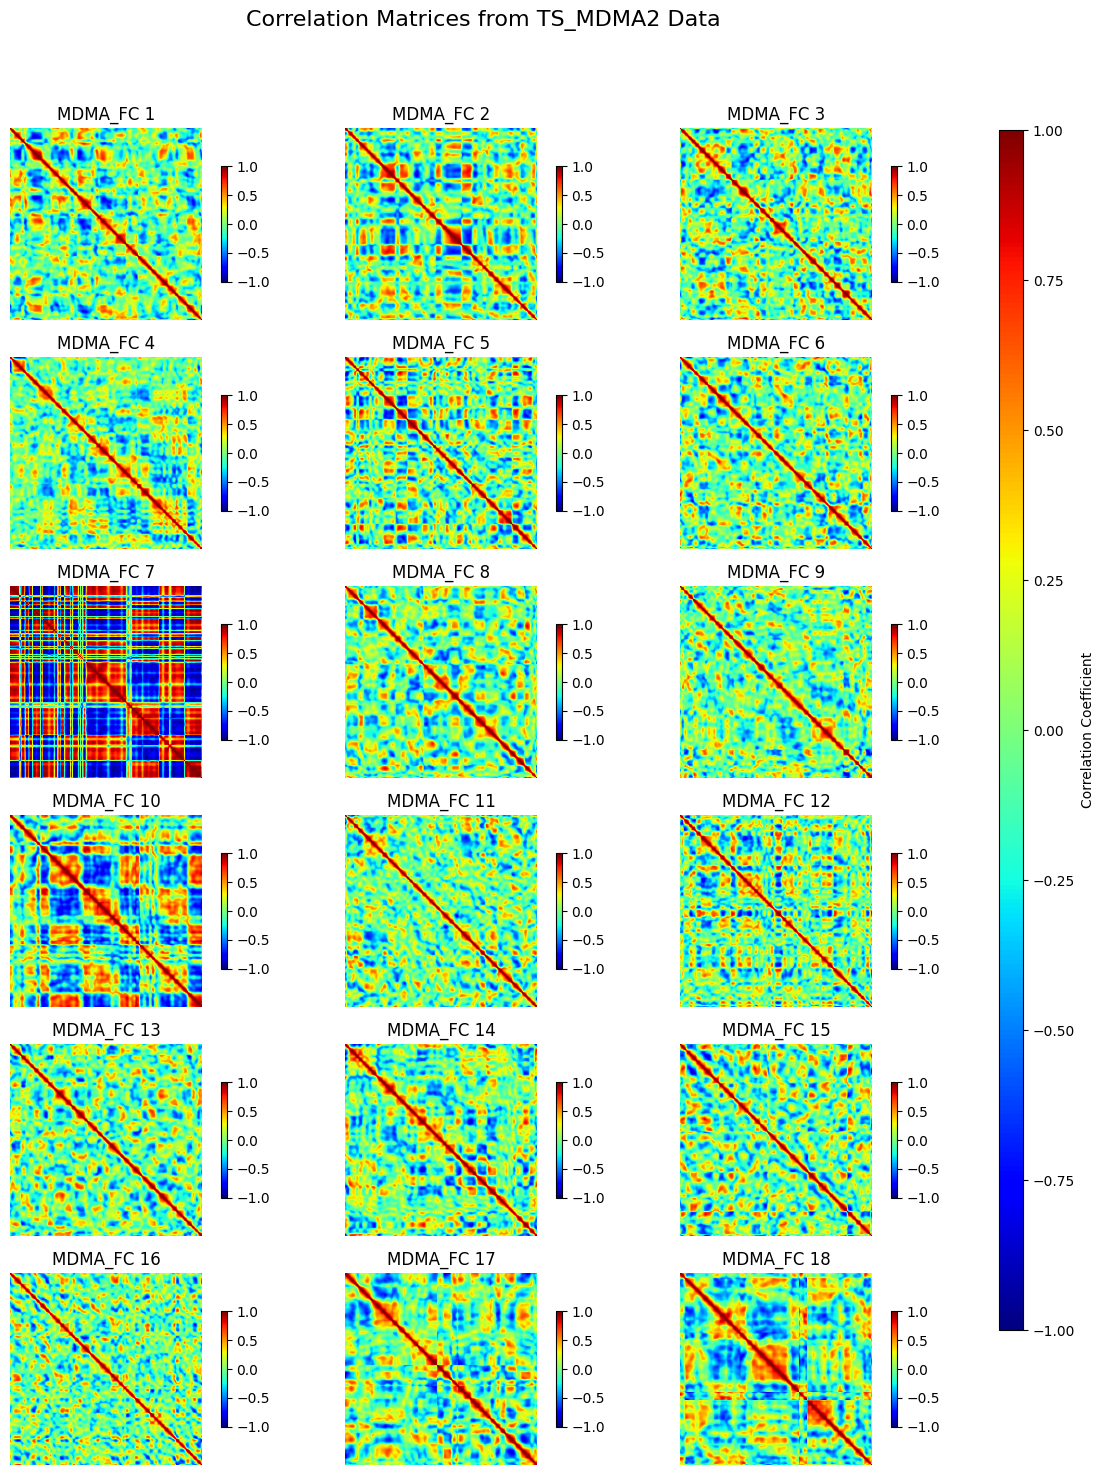

In [18]:
fig, axs = plt.subplots(6, 3, figsize=(12, 15))

for k in range(18):
    corr_mat = np.corrcoef(data_MDMA[k]['TS_MDMA2'].T)
    
    row = k // 3  
    col = k % 3
    ax = axs[row, col]
    
    # Display the correlation matrix 
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.6)
    ax.set_title(f"MDMA_FC {k+1}") 

plt.set_cmap('jet')
fig.suptitle('Correlation Matrices from TS_MDMA2 Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
cbar_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
fig.colorbar(im, cax=cbar_ax, label='Correlation Coefficient')
plt.show()


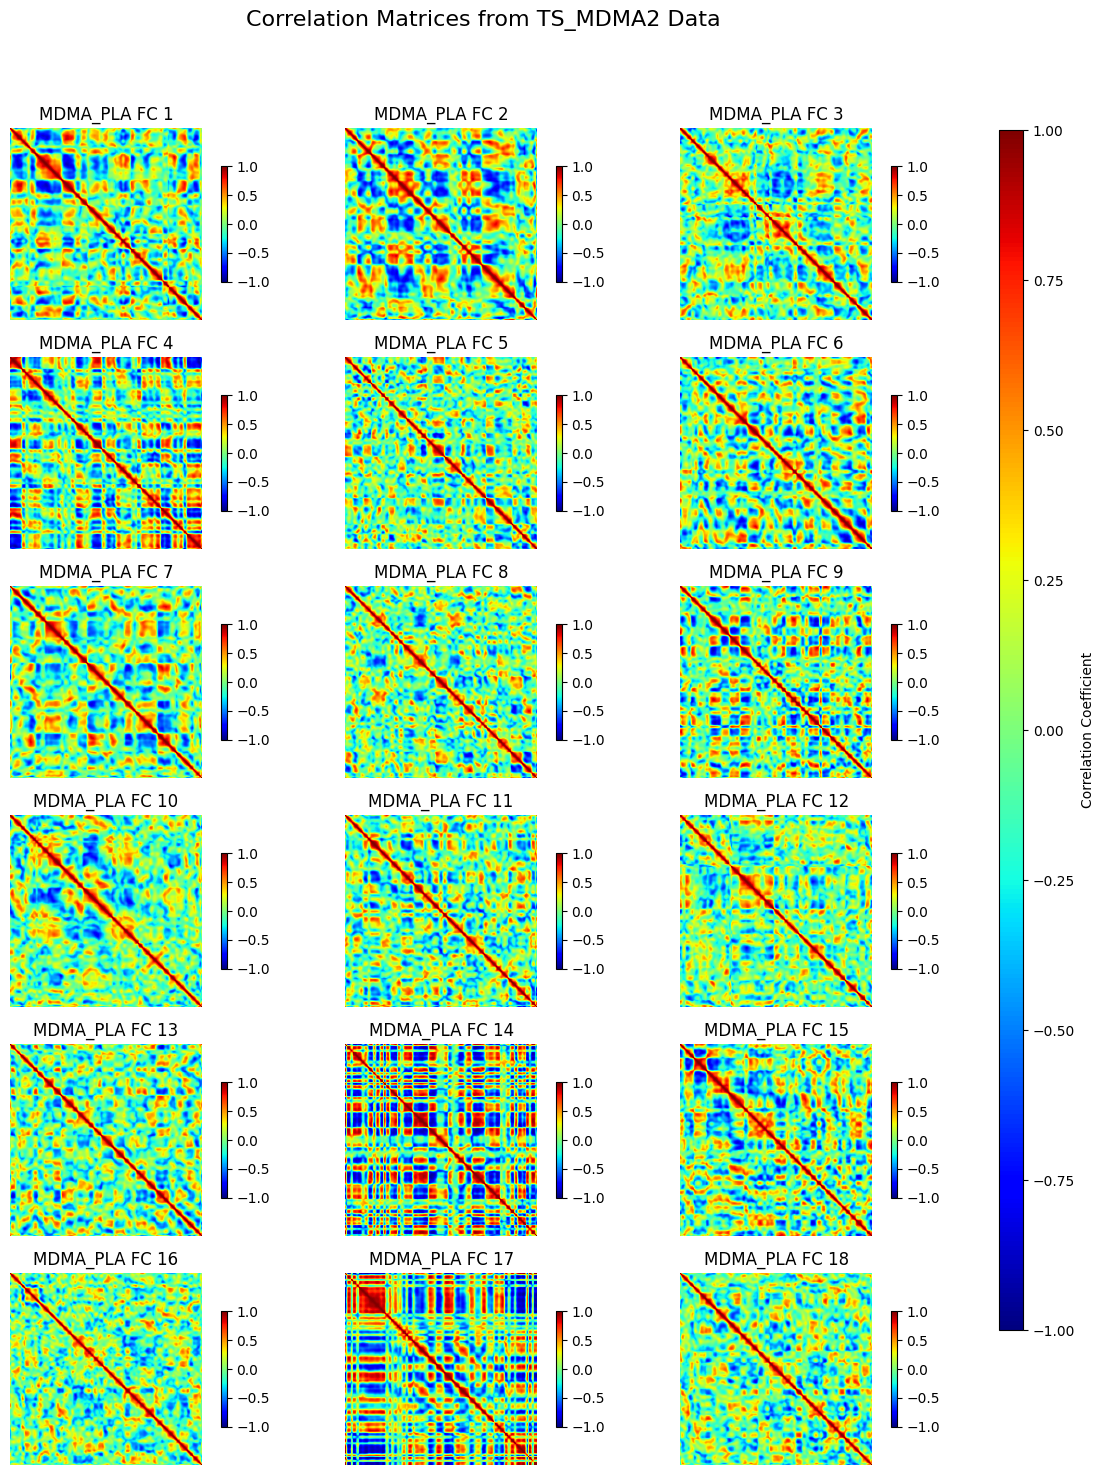

In [19]:
# PCB_TS correlation matrices
fig2, axs2 = plt.subplots(6, 3, figsize=(12, 15)) 

for k in range(18):
    # Compute the correlation matrix for PCB_TS data 
    corr_mat = np.corrcoef(data_MDMA[k]['TS_PCB2'].T)
    
    row = k // 3
    col = k % 3
    ax = axs2[row, col]
    
    im = ax.imshow(corr_mat, vmin=-1, vmax=1, cmap='jet')
    ax.axis("off")
    plt.colorbar(im, ax=ax, shrink=0.6)
    ax.set_title(f"MDMA_PLA FC {k+1}")


plt.set_cmap('jet')
fig2.suptitle('Correlation Matrices from TS_MDMA2 Data', fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
cbar_ax2 = fig2.add_axes([0.93, 0.1, 0.02, 0.8])
fig2.colorbar(im, cax=cbar_ax2, label='Correlation Coefficient')
plt.show()